<a href="https://www.kaggle.com/code/asemsaber/cyberbullying-detection?scriptVersionId=142652209" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 

import spacy 
from spacy import displacy
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re 
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from gensim.models import Word2Vec
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset
from torchsummary import summary
from torchmetrics import ConfusionMatrix 
from mlxtend.plotting import plot_confusion_matrix

lemma = WordNetLemmatizer()
lb = LabelEncoder()
nlp=spacy.load("en_core_web_lg")

# Loading Dataset

In [2]:
df = pd.read_csv('cyberbullying_tweets.csv')

In [3]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
df.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [5]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [6]:
np.unique(df['cyberbullying_type'])

array(['age', 'ethnicity', 'gender', 'not_cyberbullying',
       'other_cyberbullying', 'religion'], dtype=object)

# EDA

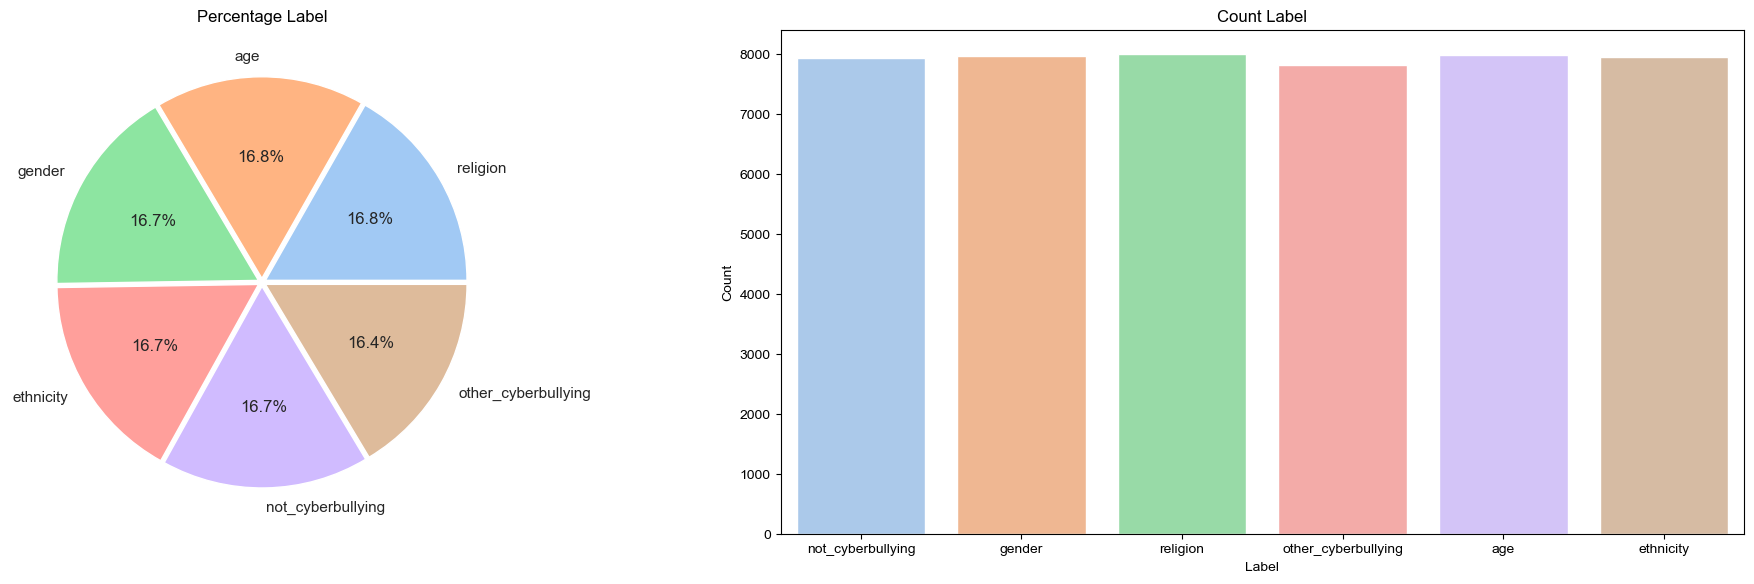

In [7]:
label_count = df['cyberbullying_type'].value_counts()
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

sns.countplot(df['cyberbullying_type'] , ax=axes[1])
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [8]:
def Most_Words_used(tweets , num_of_words) : 
    all_text = ''.join(df[tweets].values)
    
    all_text = re.sub(r'http\S+', '', all_text)
    all_text = re.sub(r'@\S+', '', all_text)
    all_text = re.sub(r'#\S+', '', all_text)
    all_text = re.sub(r'\d+', '',all_text)
    all_text = re.sub(r'[^\w\s]', '',all_text)
    
    
    words = all_text.split()
    
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words] 
    
    word_counts = Counter(words)
    
    top_words = word_counts.most_common(num_of_words)
    
    return top_words

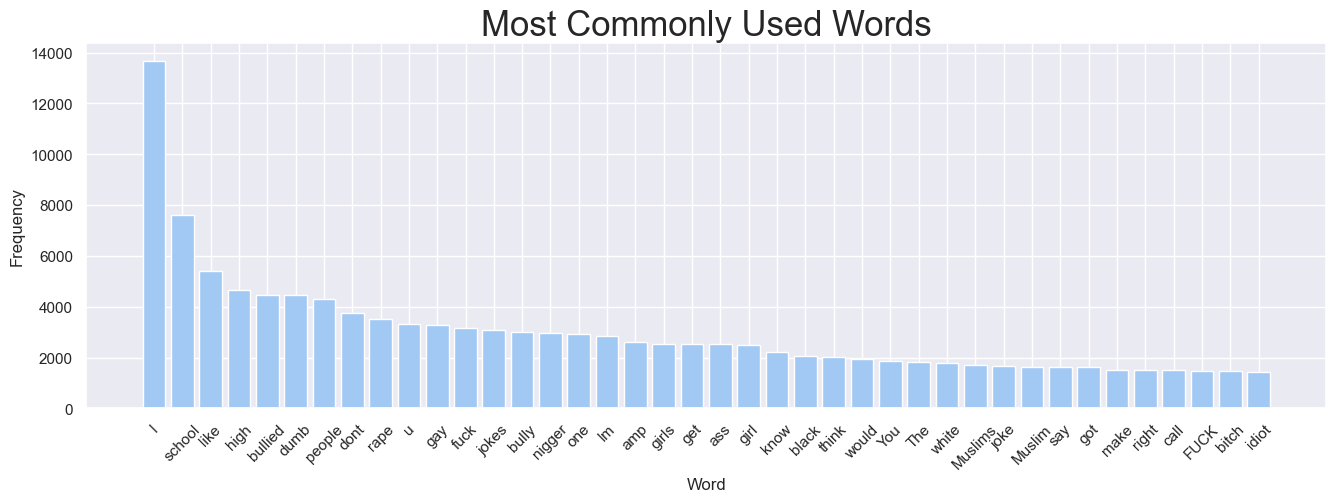

In [11]:
top_words = Most_Words_used('tweet_text' , 40)

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [12]:
ner_sent = df['tweet_text'].iloc[4]
doc = nlp(ner_sent)
displacy.render(doc, style='ent', jupyter=True)

# Data Preprocessing

In [13]:
def DataPrep(text) : 
    text = re.sub('<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = nltk.word_tokenize(text) 
    
    #remove puncs
    punc = list(punctuation) 
    words = [w for w in tokens if w not in punc]
    
    #remove stop words
    stop_words = set(stopwords.words('english'))
    words = [w.lower() for w in words if not w.lower() in stop_words]
    
    # lemmatization 
    words = [lemma.lemmatize(w) for w in words] 
    
    text = ' '.join(words) 
    
    return text

In [14]:
df['cleaned_text'] = df['tweet_text'].apply(DataPrep)

In [15]:
print(f'There are around {int(df["cleaned_text"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 3172 duplicated tweets, we will remove them.


In [16]:
df.drop_duplicates("cleaned_text", inplace=True)

In [17]:
df = df[df["cyberbullying_type"]!="other_cyberbullying"]

In [18]:
df_labels = {key : value for value , key in enumerate(np.unique(df['cyberbullying_type']))}
df_labels

{'age': 0, 'ethnicity': 1, 'gender': 2, 'not_cyberbullying': 3, 'religion': 4}

In [19]:
def getlabel(n) : 
    for x , y in df_labels.items() : 
        if y==n : 
            return x

In [20]:
df['tweet_len'] = [len(text.split()) for text in df.cleaned_text]

In [22]:
df = df[df['tweet_len'] < df['tweet_len'].quantile(0.995)]

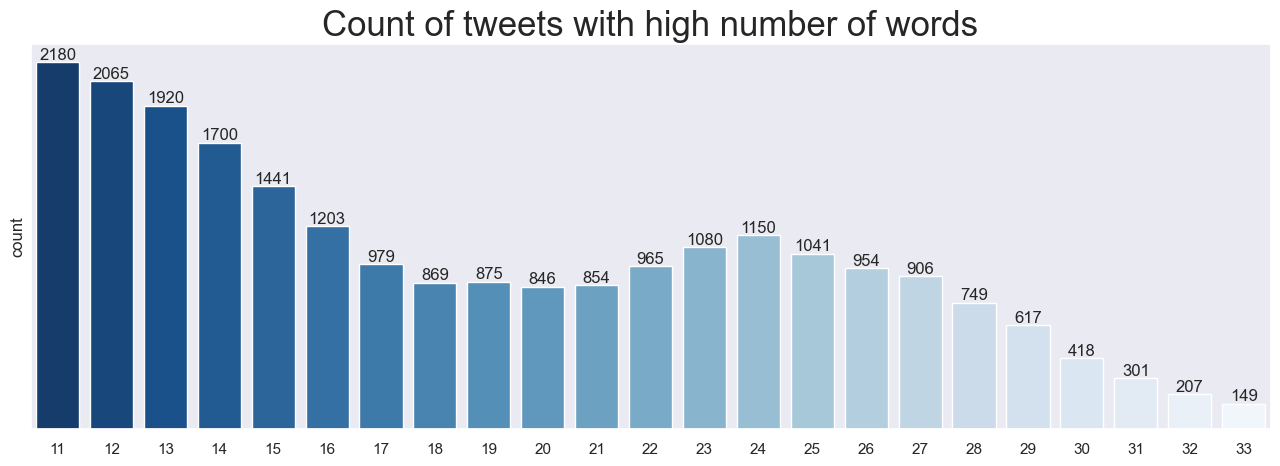

In [23]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='tweet_len', data=df[(df['tweet_len']<=1000) & (df['tweet_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

# Split the data 

In [24]:
x_train , x_test , y_train , y_test = train_test_split(df['cleaned_text'] , df['cyberbullying_type'] , train_size = 0.80)

# Feature Extraction

In [25]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
print("No. of feature words: ",len(vectorizer.get_feature_names()))

No. of feature words:  33167


In [26]:
x_train = vectorizer.transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()

In [27]:
train_vectors = pd.DataFrame(x_train,columns=vectorizer.get_feature_names_out())

In [28]:
for i in range(5) : 
    print(sorted(list(train_vectors.iloc[i,:]),reverse = True)[:20])
    print('--------------------------------------------------')

[0.46309656178840436, 0.2624108584241843, 0.2524135174138886, 0.24532029108359288, 0.23532295007329715, 0.22532560906300148, 0.20443422906952224, 0.20219118553544577, 0.1964757744282345, 0.19563988160761348, 0.19183906895472572, 0.16910607470450936, 0.16428593025931282, 0.1585546322464306, 0.15801270984396715, 0.1578346839676923, 0.15713516253359414, 0.14886358681163403, 0.12947910746154598, 0.12088778794526588]

--------------------------------------------------

[0.44941952893780823, 0.43101473629576276, 0.42710875442796037, 0.3824382251140271, 0.35192679701969715, 0.2609012307311115, 0.22204454551487804, 0.2057712251928853, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

--------------------------------------------------

[0.4965261622856848, 0.2630589541451894, 0.2571591855580338, 0.2482630811428424, 0.2340123685191475, 0.2264062439229276, 0.2264062439229276, 0.19473976006881574, 0.1804475088008556, 0.17616514640469835, 0.17448969553256796, 0.16776791229219157, 0.16293

# Encoding

In [29]:
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

# Logistic Regression

In [30]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train , y_train)

LogisticRegression(random_state=42)

In [31]:
train_acc1 = lr.score(x_train , y_train)

In [32]:
lr_pred = lr.predict(x_test)

test_acc1 = accuracy_score(y_test , lr_pred) 

test_precision1 = precision_score(y_test , lr_pred , average='weighted')
test_recall1 = recall_score(y_test , lr_pred , average='weighted')
test_f1score1 = f1_score(y_test , lr_pred , average='weighted')

In [33]:
print(f"The training accuracy for logistic regression : {(train_acc1*100):0.2f}%\n")
print(f"The testing accuracy for logistic regression : {(test_acc1*100):0.2f}%\n")
print(f"The precision for logistic regression : {test_precision1:0.2f}\n")
print(f"The recall for logistic regression : {test_recall1:0.2f}\n")
print(f"The f1 score for logistic regression : {test_f1score1:0.2f}\n")

The training accuracy for logistic regression : 94.89%



The testing accuracy for logistic regression : 92.02%



The precision for logistic regression : 0.92



The recall for logistic regression : 0.92



The f1 score for logistic regression : 0.92




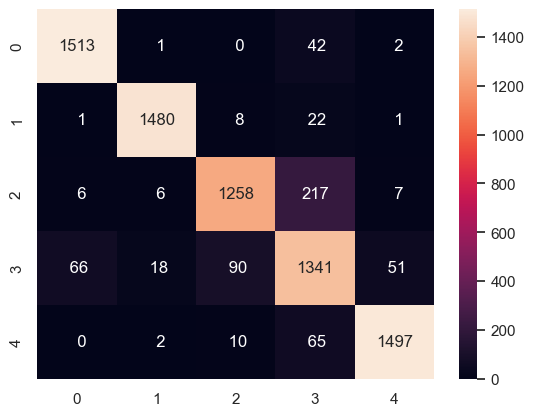

In [34]:
lr_cm = confusion_matrix(y_test , lr_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

# Random Forest Classifier

In [35]:
rf = RandomForestClassifier()
rf.fit(x_train , y_train)

RandomForestClassifier()

In [36]:
train_acc2 = rf.score(x_train , y_train)

In [37]:
rf_pred = rf.predict(x_test)

test_acc2 = accuracy_score(y_test , lr_pred) 

test_precision2 = precision_score(y_test , rf_pred , average='weighted')
test_recall2 = recall_score(y_test , rf_pred , average='weighted')
test_f1score2 = f1_score(y_test , rf_pred , average='weighted')

In [38]:
print(f"The training accuracy for Random Forest : {(train_acc2*100):0.2f}%\n")
print(f"The testing accuracy for Random Forest : {(test_acc2*100):0.2f}%\n")
print(f"The precision for Random Forest : {test_precision2:0.2f}\n")
print(f"The recall for Random Forest : {test_recall2:0.2f}\n")
print(f"The f1 score for Random Forest : {test_f1score2:0.2f}\n")

The training accuracy for Random Forest : 99.99%



The testing accuracy for Random Forest : 92.02%



The precision for Random Forest : 0.93



The recall for Random Forest : 0.93



The f1 score for Random Forest : 0.93




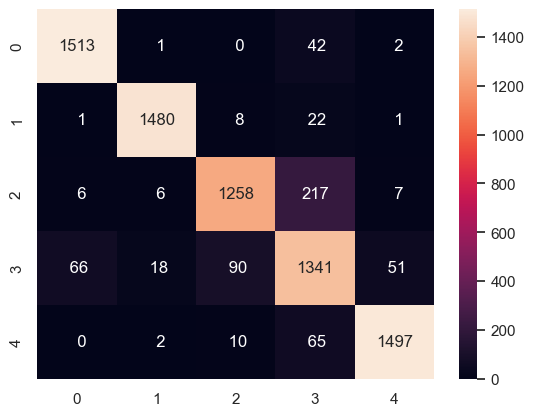

In [39]:
rf_cm = confusion_matrix(y_test , rf_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

# LSTM

Data preprocessing for LSTM

In [40]:
max_len = np.max(df['tweet_len'])
max_len

33

In [41]:
def lstm_prep(column , seq_len) : 
    # create a vocab of words 
    corpus = [word for text in column for word in text.split()]
    words_count = Counter(corpus) 
    sorted_words = words_count.most_common()
    vocab_to_int = {w:i+1 for i , (w,c) in enumerate(sorted_words)}
    
    text_int = [] 
    
    for text in column : 
        token = [vocab_to_int[word] for word in text.split()]
        text_int.append(token)
        
        
    # add padding 
    features = np.zeros((len(text_int) , seq_len) , dtype = int)
    for idx , y in tqdm(enumerate(text_int)) : 
        if len(y) <= seq_len : 
            zeros = list(np.zeros(seq_len - len(y)))
            new = zeros + y
            
        else : 
            new = y[:seq_len]
            
        features[idx,:] = np.array(new)
        
    return sorted_words, features

In [42]:
vocab , tokenized_column = lstm_prep(df['cleaned_text'] , max_len)

0it [00:00, ?it/s]

In [43]:
vocab[:10]

[('school', 8934),
 ('fuck', 5705),
 ('girl', 5385),
 ('like', 5377),
 ('nigger', 5349),
 ('joke', 5170),
 ('dumb', 5093),
 ('high', 4978),
 ('u', 4831),
 ('muslim', 4663)]

In [44]:
len(vocab)

37968

In [45]:
tokenized_column.shape

(38520, 33)

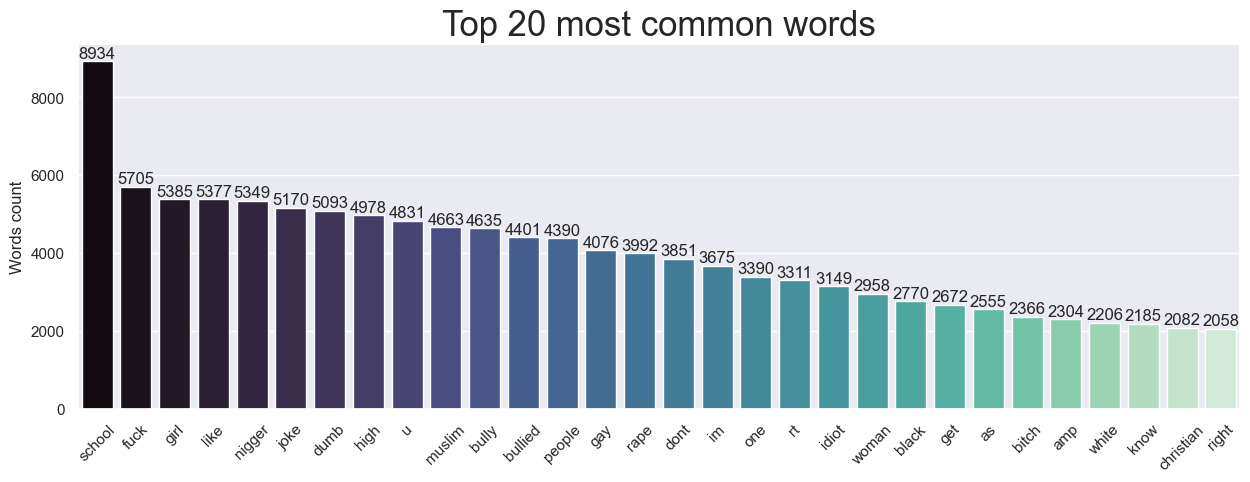

In [46]:
def most_common_words(vocab) : 
    keys = [] 
    values = [] 
    for key , value in vocab[:30] : 
        keys.append(key) 
        values.append(value)
        
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(keys, values, palette='mako')
    plt.title('Top 20 most common words', size=25)
    ax.bar_label(ax.containers[0])
    plt.ylabel("Words count")
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    
most_common_words(vocab)

In [47]:
X = tokenized_column
y = lb.fit_transform(df['cyberbullying_type'].values)

In [48]:
X_train , X_test , Y_train , Y_test = train_test_split(X , y , train_size=0.80 , random_state=42)

In [49]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.LongTensor(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.LongTensor(Y_test))

In [50]:
BATCH_SIZE = 32

Create DataLoaders

In [51]:
torch.manual_seed(42)
train_dataloader = DataLoader(
    dataset = train_data , 
    batch_size=BATCH_SIZE , 
    shuffle=True
)

In [52]:
torch.manual_seed(42) 
test_dataloader = DataLoader(
    dataset = test_data , 
    batch_size = BATCH_SIZE , 
    shuffle=False
)

In [53]:
print(f"the size of the test dataloader {len(train_dataloader)} batches of {BATCH_SIZE}")

the size of the test dataloader 963 batches of 32


In [54]:
print(f"the size of the test dataloader {len(test_dataloader)} batches of {BATCH_SIZE}")

the size of the test dataloader 241 batches of 32


Build our model 

In [57]:
def param_count(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print('The Total number of parameters in the model : ', sum(params))

In [58]:
class LSTM(nn.Module) : 
    def __init__(self , vocab_size , embedding_dim 
                 , num_layers , hidden_dim , out_channels , bidirectional) : 
        super().__init__() 
         
        self.no_layers = num_layers 
        self.hidden_dim = hidden_dim 
        self.out_channels = out_channels
        self.num_directions = 2 if bidirectional else 1  
        self.embedding = nn.Embedding(vocab_size , embedding_dim)
        
        self.lstm = nn.LSTM(
            embedding_dim , 
            hidden_dim , 
            num_layers , 
            dropout = 0.5 , 
            bidirectional = bidirectional , 
            batch_first = True
        )
        
        self.fc = nn.Linear(hidden_dim*self.num_directions , out_channels)
        
        
    def forward(self , x) : 
        h0 = torch.zeros((self.no_layers * self.num_directions , x.size(0) , self.hidden_dim))
        c0 = torch.zeros((self.no_layers * self.num_directions , x.size(0) , self.hidden_dim))
        
        embedded = self.embedding(x)
        
        out , _ = self.lstm(embedded , (h0 , c0))
        
        out = out[:,-1,:]
        
        out = self.fc(out)
        
        return out 

In [59]:
# define parameters 
EMBEDDING_DIM = 200
VOCAB_SIZE = len(vocab) + 1
NUM_LAYERS = 2 
OUT_CHANNELS = 5 
HIDDEN_DIM = 256
BIDIRECTIONAL = True

model = LSTM(VOCAB_SIZE , EMBEDDING_DIM , NUM_LAYERS , HIDDEN_DIM , OUT_CHANNELS , BIDIRECTIONAL)

In [60]:
param_count(model)

The Total number of parameters in the model :  10111309


In [61]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=0.001)

Train our model

In [62]:
epochs = 10 
training_loss = []
training_acc = [] 
for i in tqdm(range(epochs)) : 
    epoch_loss = 0
    epoch_acc = 0 
    for batch , (x_train , y_train) in enumerate(train_dataloader) : 
        y_pred = model(x_train)
        
        loss = criterion(y_pred , y_train) 
        
        if batch % 500 == 0:
            print(f"Looked at {batch * len(x_train)}/{len(train_dataloader.dataset)} samples.")
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss +=loss 
        epoch_acc += accuracy_score(y_train , y_pred.argmax(dim=1))
        
    training_loss.append((epoch_loss/len(train_dataloader)).detach().numpy())
    training_acc.append(epoch_acc/len(train_dataloader))
    
    print(f"Epoch {i+1}: Accuracy: {(epoch_acc/len(train_dataloader)) * 100}, Loss: {(epoch_loss/len(train_dataloader))}\n\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/30816 samples.

Looked at 16000/30816 samples.

Epoch 1: Accuracy: 87.93483904465212, Loss: 0.3491450548171997





Looked at 0/30816 samples.

Looked at 16000/30816 samples.

Epoch 2: Accuracy: 93.02310488058151, Loss: 0.2008281648159027





Looked at 0/30816 samples.

Looked at 16000/30816 samples.

Epoch 3: Accuracy: 95.10643821391484, Loss: 0.1384839117527008





Looked at 0/30816 samples.

Looked at 16000/30816 samples.

Epoch 4: Accuracy: 96.94963655244028, Loss: 0.09042306244373322





Looked at 0/30816 samples.

Looked at 16000/30816 samples.

Epoch 5: Accuracy: 98.00428348909658, Loss: 0.057362496852874756





Looked at 0/30816 samples.

Looked at 16000/30816 samples.

Epoch 6: Accuracy: 98.65005192107996, Loss: 0.037643566727638245





Looked at 0/30816 samples.

Looked at 16000/30816 samples.

Epoch 7: Accuracy: 98.98753894080997, Loss: 0.028230613097548485





Looked at 0/30816 samples.

Looked at 16000/30816 samples.

Epoch 8: Accuracy: 99.23091900311528,

In [63]:
print(f"The loss of the training set is : {training_loss[-1]:0.2f}")
print(f"The accuracy of the training set is : {(training_acc[-1]*100):0.2f}%")

The loss of the training set is : 0.01

The accuracy of the training set is : 99.57%


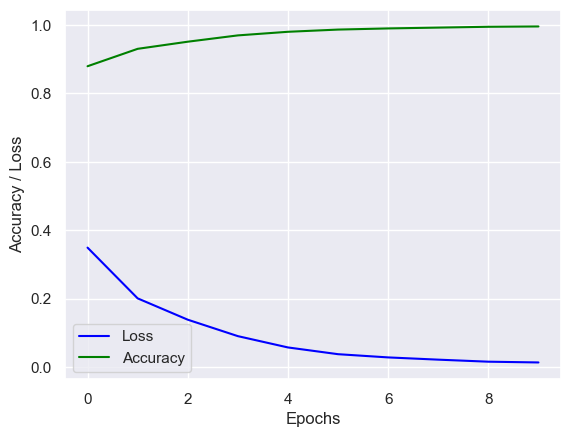

In [64]:
plt.plot(range(epochs),training_loss,color="blue",label="Loss")
plt.plot(range(epochs),training_acc,color="green",label="Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

Test our model

In [189]:
test_loss=0
test_acc3= 0
lstm_preds=[]
test_targets = []
torch.manual_seed(42)
with torch.no_grad() : 
        for x_test , y_test in tqdm(test_dataloader) : 
            y_pred=model.forward(x_test)
            test_pred = torch.softmax(y_pred , dim=1 ).argmax(dim=1)
            lstm_preds.append(test_pred)
            test_targets.extend(y_test)
            
            loss=criterion(y_pred,y_test)
            test_loss+=loss
            test_acc3 += accuracy_score(y_test , y_pred.argmax(dim=1))
            
            
test_loss/=len(test_dataloader)
test_acc3/=len(test_dataloader)
lstm_preds = torch.cat(lstm_preds)
test_targets = torch.Tensor(test_targets)

  0%|          | 0/241 [00:00<?, ?it/s]

In [190]:
train_acc3 = training_acc[-1]
test_precision3 = precision_score(test_targets,lstm_preds,average='weighted')
test_recall3 = recall_score(test_targets,lstm_preds,average='weighted')
test_f1score3 = f1_score(test_targets,lstm_preds,average='weighted')

Measuring performance

In [191]:
print(f"The training accuracy for LSTM : {(train_acc3*100):0.2f}%\n")
print(f"The testing accuracy for LSTM : {(test_acc3*100):0.2f}%\n")
print(f"The precision for LSTM : {test_precision3:0.2f}\n")
print(f"The recall for LSTM : {test_recall3:0.2f}\n")
print(f"The f1 score for LSTM : {test_f1score3:0.2f}\n")
print(f"The training loss for LSTM : {training_loss[-1]:0.2f}\n")
print(f"The testing loss for LSTM : {test_loss:0.2f}\n")

The training accuracy for LSTM : 99.57%



The testing accuracy for LSTM : 91.03%



The precision for LSTM : 0.91



The recall for LSTM : 0.91



The f1 score for LSTM : 0.91



The training loss for LSTM : 0.01



The testing loss for LSTM : 0.51




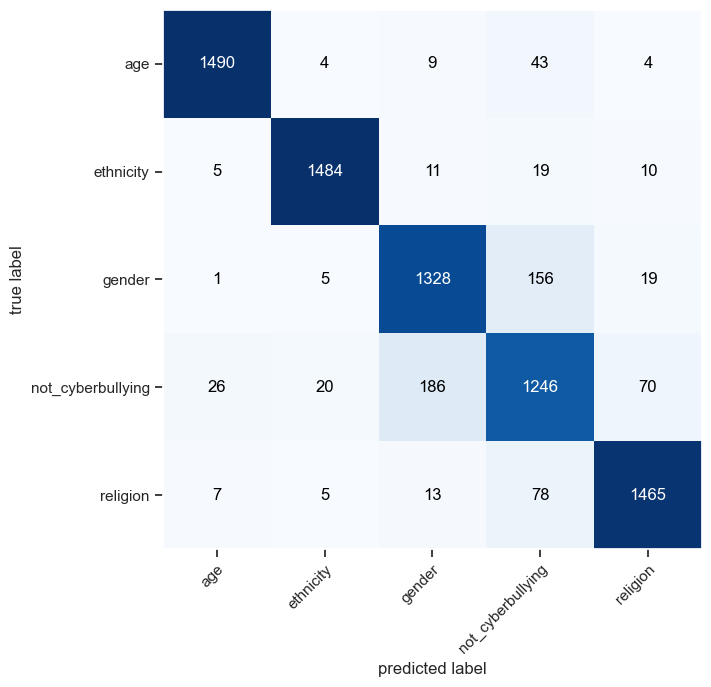

In [68]:
confmat = ConfusionMatrix(num_classes=5, task='multiclass')
confmat_tensor = confmat(preds=lstm_preds,
                         target=test_targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=df_labels.keys(),
    figsize=(10, 7)
)

# Compare between models

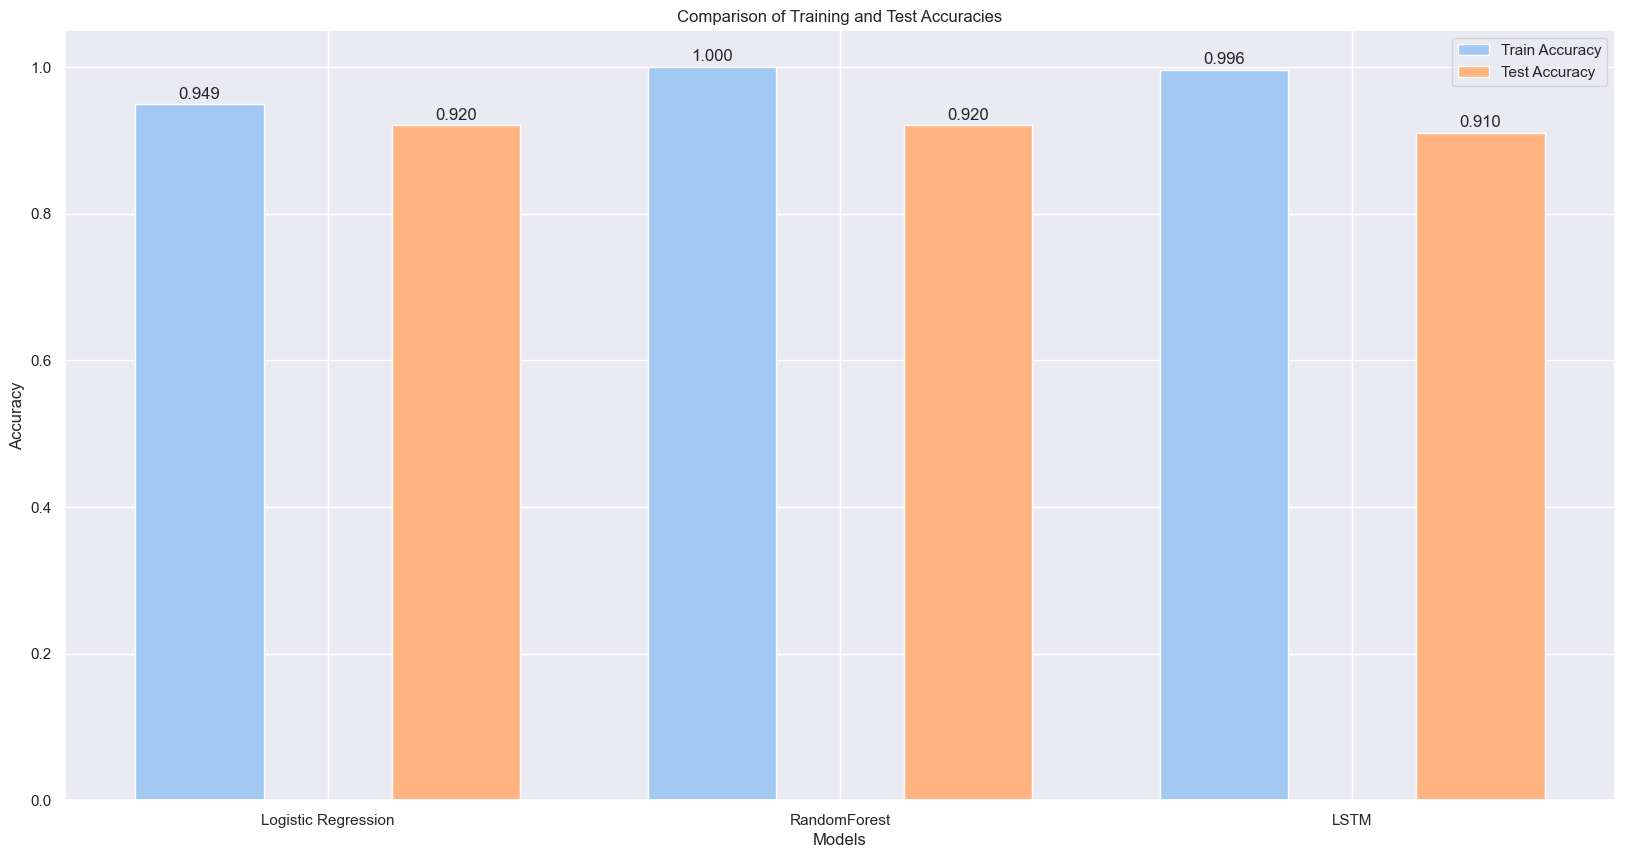

In [69]:
train_scores=[train_acc1,train_acc2,train_acc3]
test_scores=[test_acc1,test_acc2,test_acc3]

models = ['Logistic Regression','RandomForest','LSTM']

x = np.arange(len(models))

width = 0.25

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = ax.bar(x - width, train_scores, width, label='Train Accuracy')

rects2 = ax.bar(x + width, test_scores, width, label='Test Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Training and Test Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()